<h1> Brain Tumor Classification </h1>
<hr>

<h2> Importing Libraries and Dataset </h2>

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob 
import cv2
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

<h2> Creating The DataFrame </h2>

In [31]:
masks = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
brain_mri = []
for i in masks:
    brain_mri.append(i.replace('_mask', ''))

In [32]:
df = pd.DataFrame({
    "mri_path": brain_mri,
    "mask_path": masks
})

In [33]:
def positive_negative_diagnosis(masks):
    mask = cv2.imread(masks) 
    value = np.max(mask)
    if value > 0:
        return 1 # Tumor
    else:
        return 0 # no Tumor
df["Tumor"] = df["mask_path"].apply(lambda x:positive_negative_diagnosis(x))

In [34]:
# Final DataFrame
df.head()

mri_path  \
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                           mask_path  Tumor  
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      0  
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      0  
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      1  
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      1  
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...      1

In [35]:
# Ensure that mri_path and mask_path correspond to the same individual
df.mri_path[0], df.mask_path[0]

('../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif')

<h2> Data Visualization

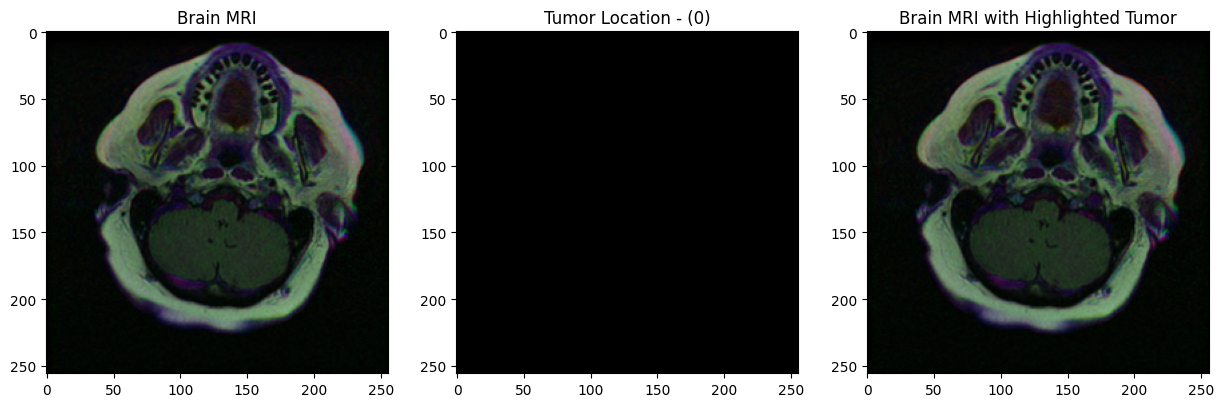

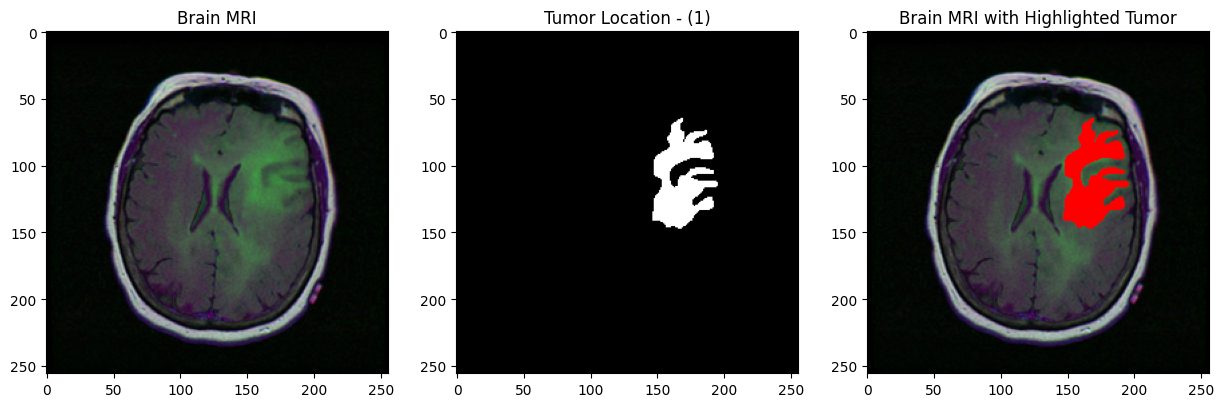

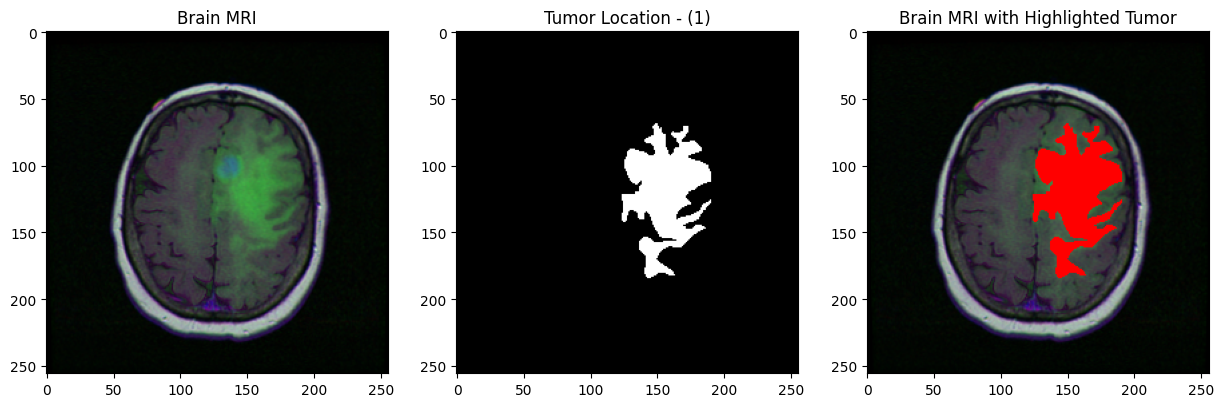

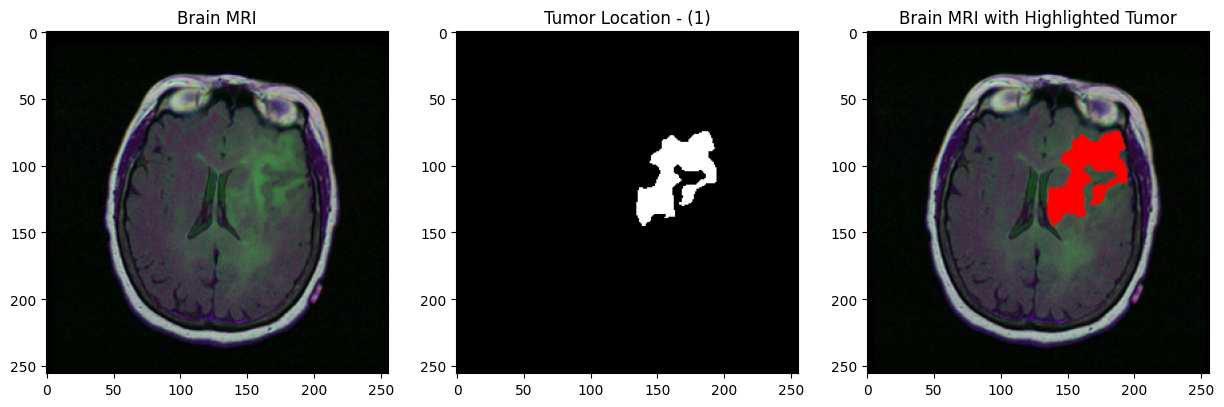

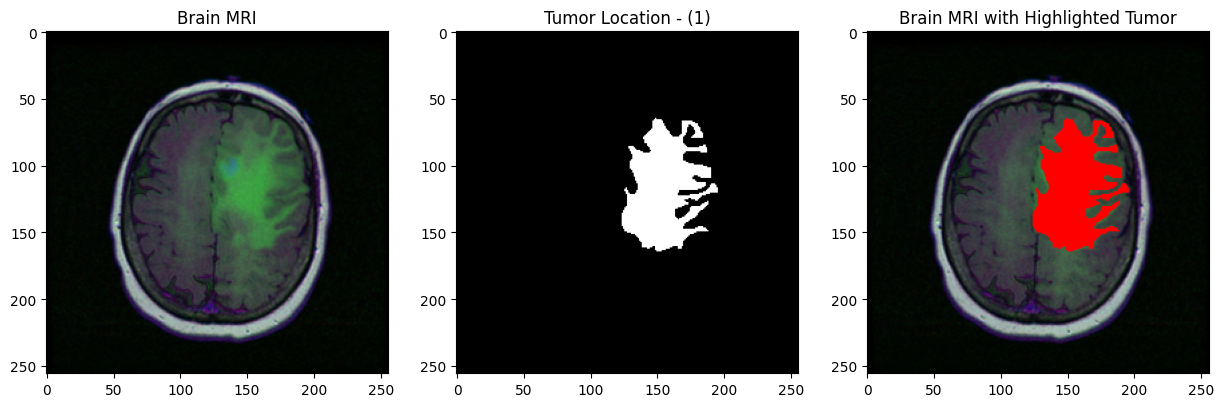

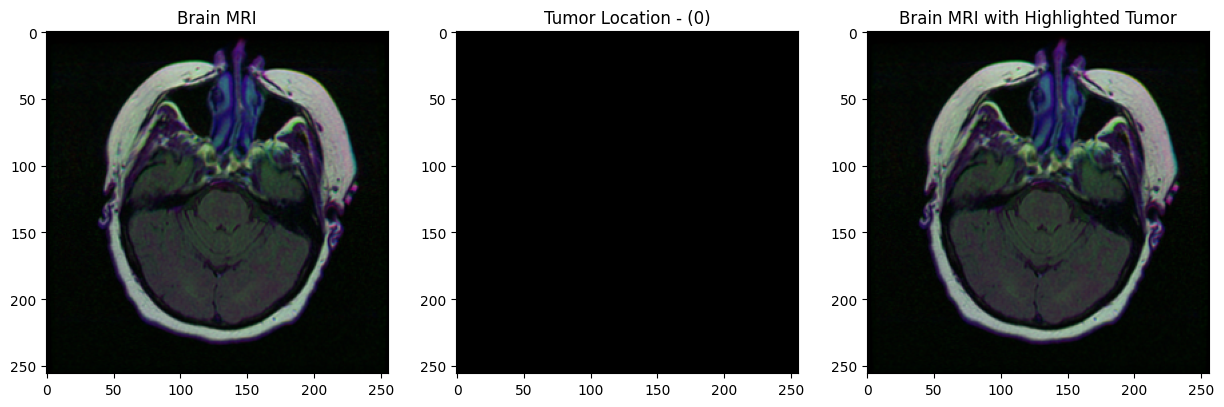

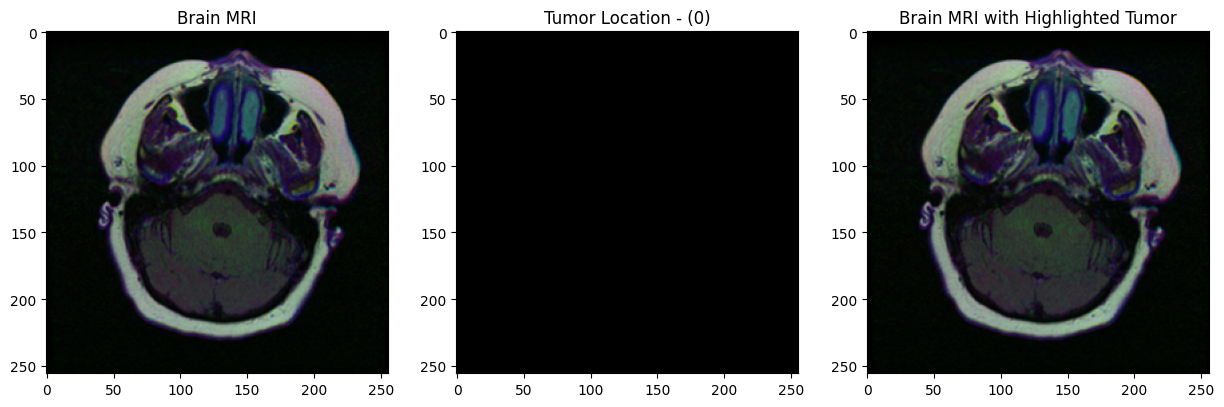

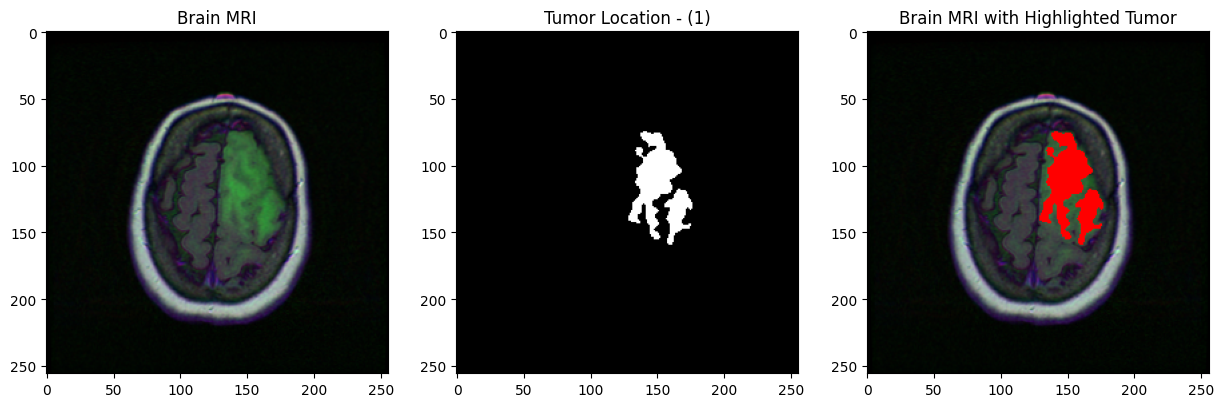

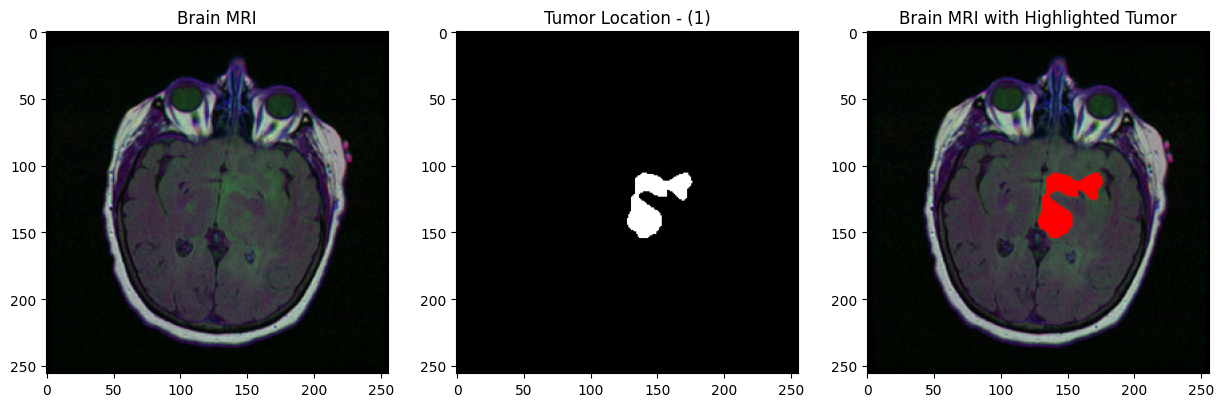

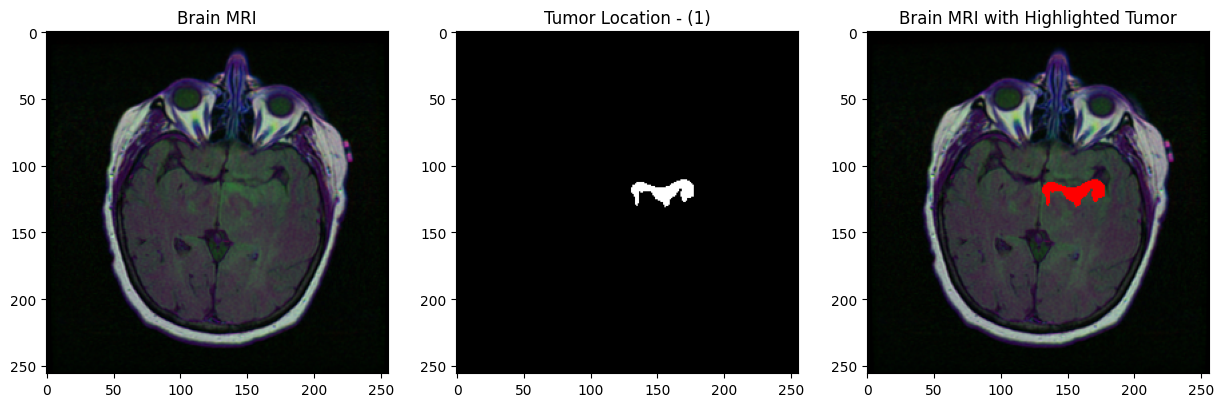

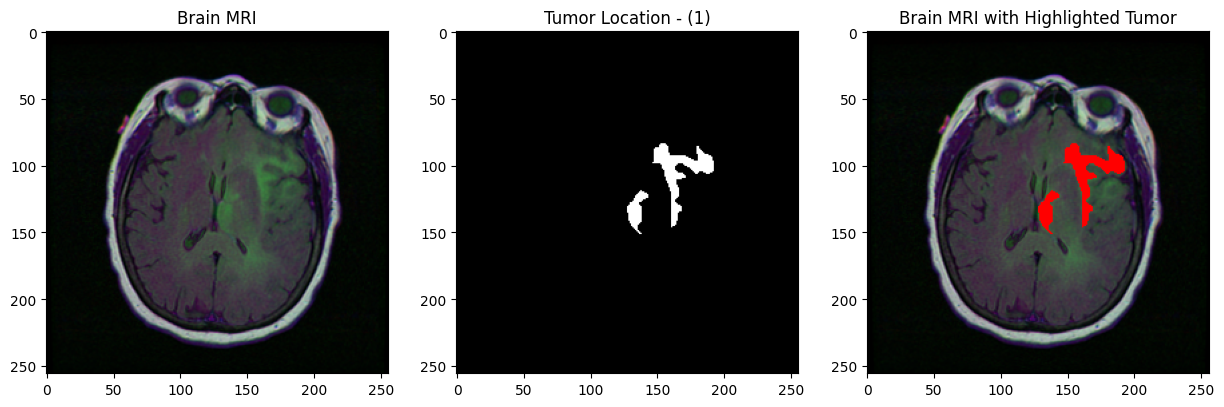

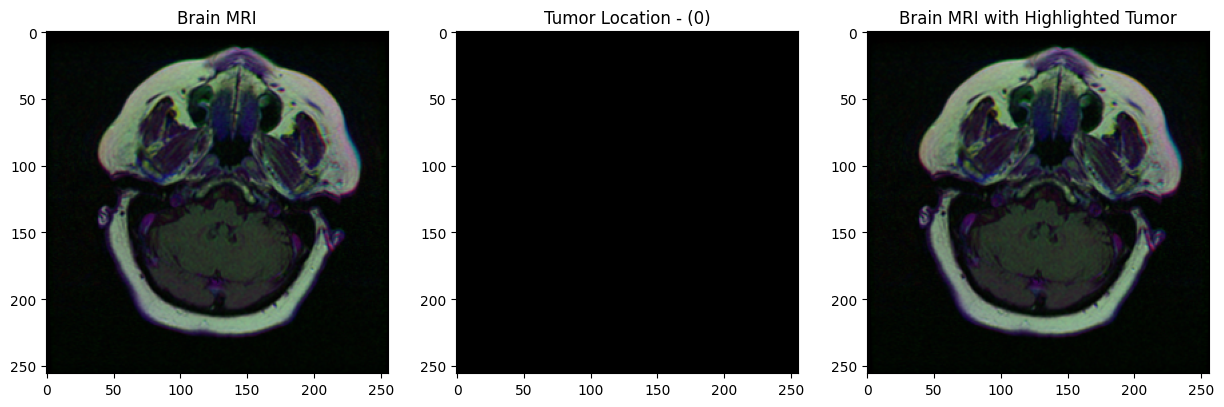

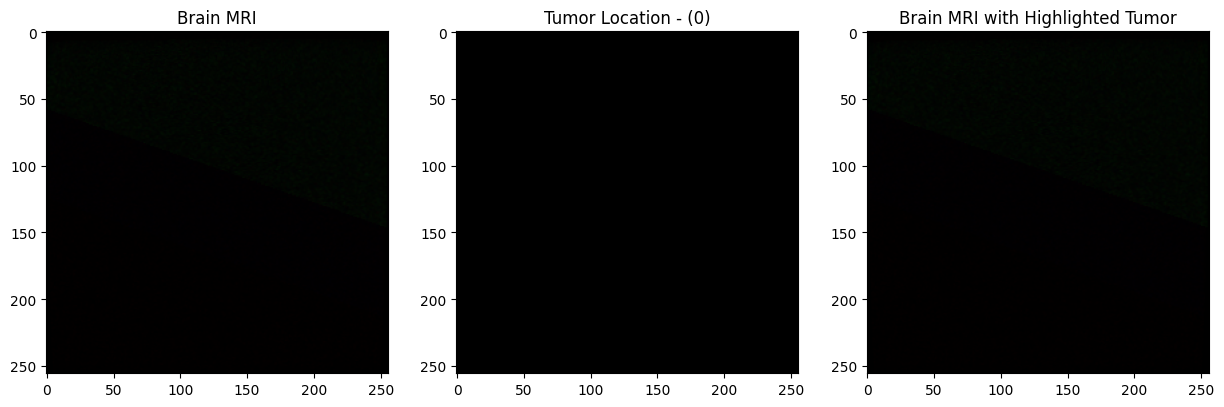

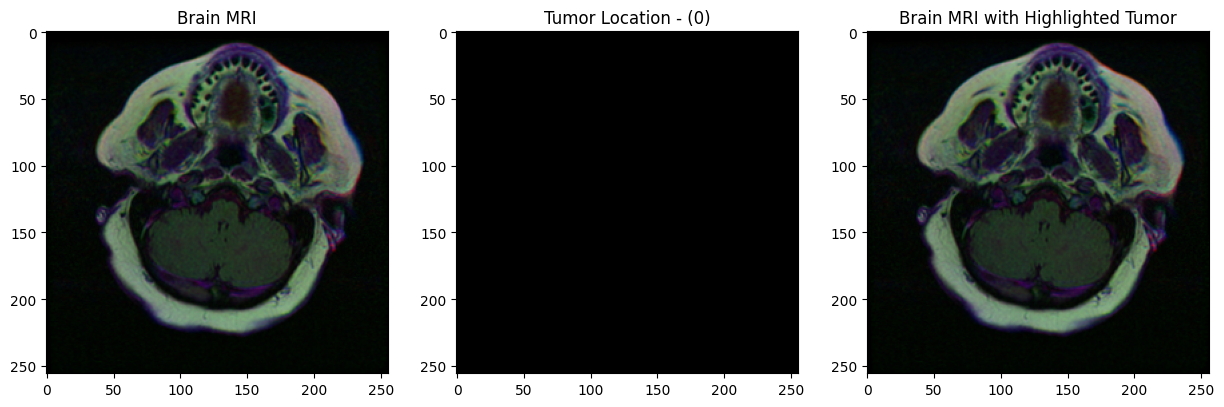

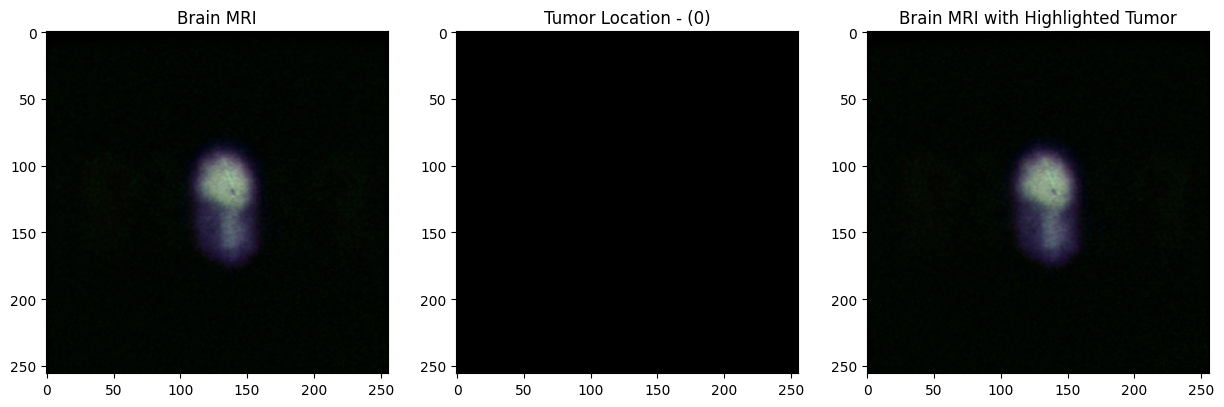

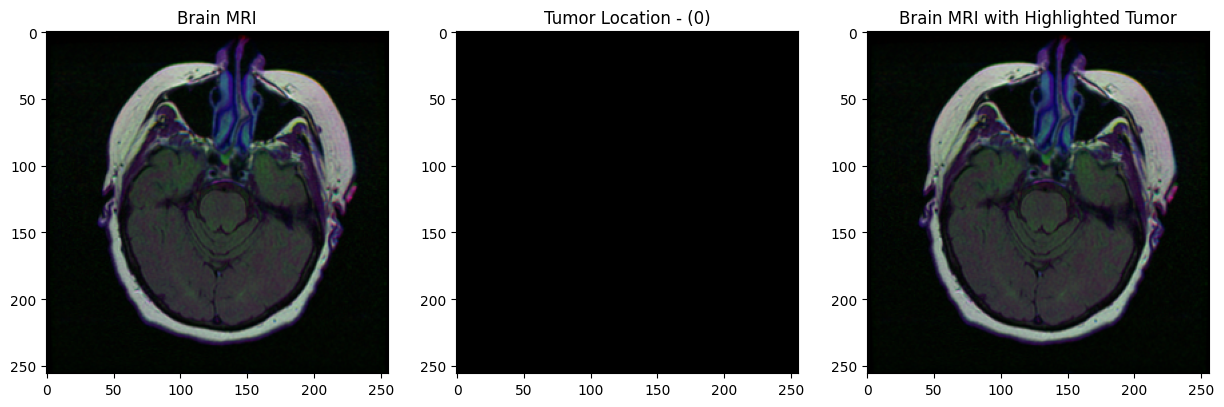

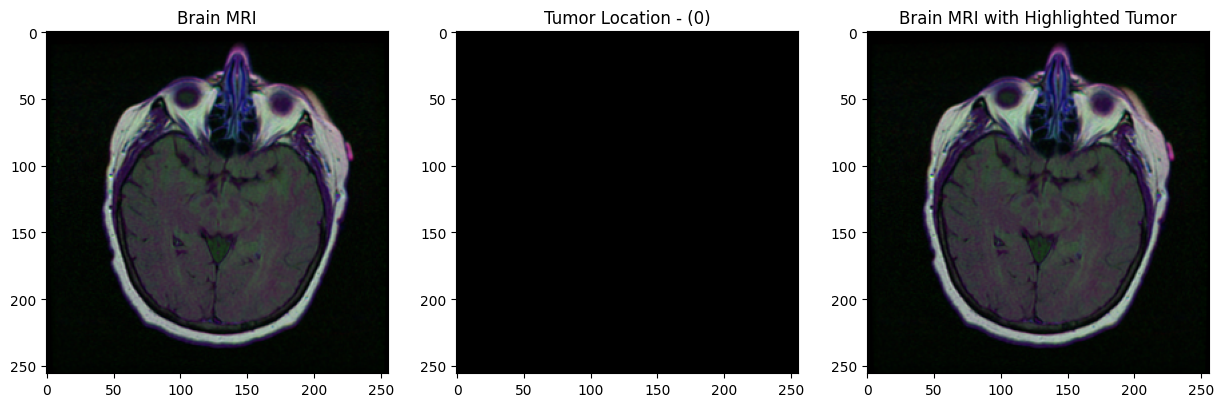

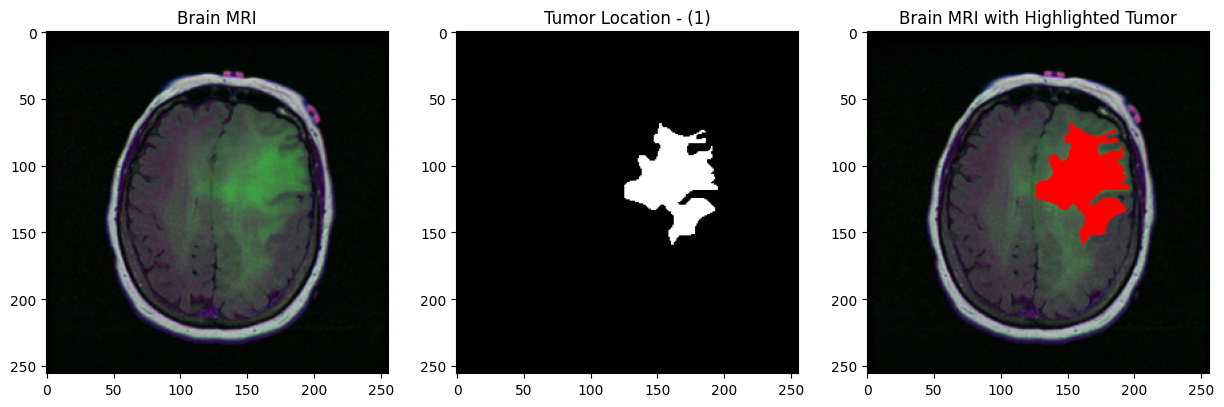

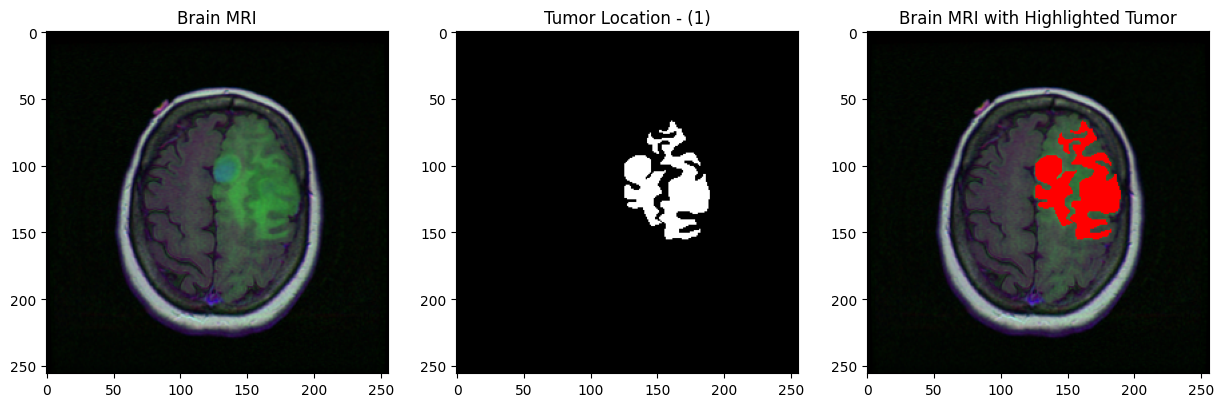

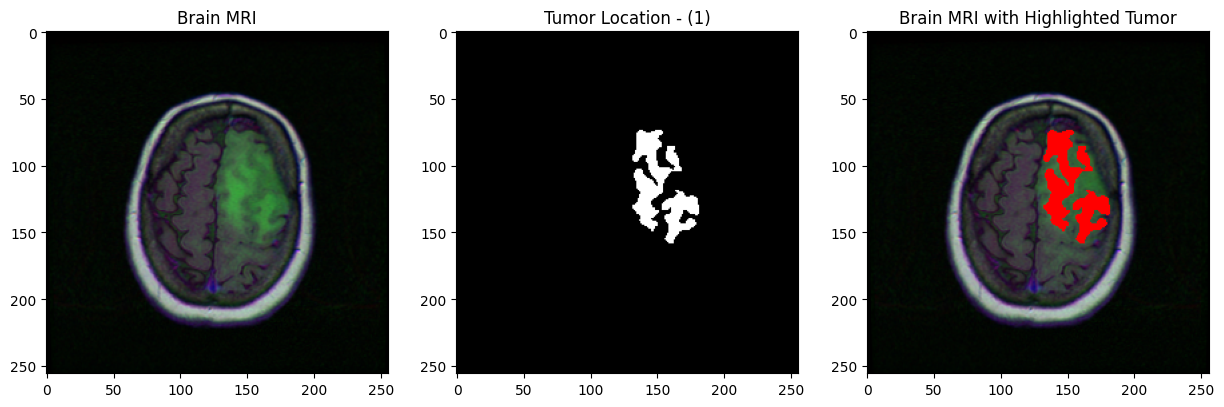

In [37]:
for i in range(1,40, 2):
    img_path = df.mri_path[i]
    msk_path = df.mask_path[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)

    #Plot the Brain MRI scans
    original = img.copy()
    fig, ax = plt.subplots(1,3,figsize = (15,5))
    ax[0].imshow(original)
    ax[0].set_title("Brain MRI")

    # Plot the corresponding mask
    main = original.copy()
    mask = msk.copy()
    ax[1].imshow(mask)
    ax[1].set_title(f"Tumor Location - ({df['Tumor'][i]})")

    # Plot the Brain MRI scan with their mask
    main = original.copy()
    label = cv2.imread(msk_path)
    sample = np.array(np.squeeze(label), dtype = np.uint8)
    contours, hier = cv2.findContours(sample[:,:,0],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(main, contours, -1,[255,0,0], thickness=-1)
    ax[2].imshow(sample_over_gt)
    ax[2].set_title("Brain MRI with Highlighted Tumor")

<h2> Data Distribution

In [38]:
df['Tumor'].value_counts()

Tumor
0    2556
1    1373
Name: count, dtype: int64

In [41]:
fig = go.Figure()

class_distribution_df = df['Tumor'].value_counts()

colors = ['#0504AA', '#ED0101']  

for class_label in class_distribution_df.index:
    class_name = 'Tumor' if class_label == 1 else 'Normal'
    
    fig.add_trace(go.Bar(
        x=[class_name],  # Only one label
        y=[class_distribution_df[class_label]],
        name=f'{class_name}',
        marker=dict(color=colors[class_label]),
        opacity=0.75,
        width=0.3
    ))

fig.update_layout(
    height=600,
    width=700,
    title_text="Class Distribution",
    title_font=dict(size=25, family='Balto'),
    title_x=0.5,
    title_y=0.98,
    xaxis=dict(title='Class', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),
    yaxis=dict(title='Count', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),
    margin=dict(l=60, r=20, t=50, b=40),
    legend=dict(x=0.73, y=0.98, traceorder='normal', orientation='h', font=dict(family='Balto')),
    barmode='stack'
)

fig.show()

<h2> Spliting The DataFrame into Training, Validation, and Test sets </h2>

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   mri_path   3929 non-null   object
 1   mask_path  3929 non-null   object
 2   Tumor      3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


In [43]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
df['Tumor'] = df['Tumor'].apply(lambda x: str(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   mri_path   3929 non-null   object
 1   mask_path  3929 non-null   object
 2   Tumor      3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [46]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [47]:
!pip install keras_preprocessing

In [48]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='mri_path',
                                              y_col='Tumor',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='mri_path',
                                              y_col='Tumor',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='mri_path',
                                                  y_col='Tumor',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 2829 validated image filenames belonging to 2 classes.
Found 314 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


<h2> Train a Classifier Model To Detect If Tumor Exists or not 

In [50]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

In [51]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [52]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layers.trainable = False

In [54]:
head = base_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(base_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )

In [55]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,751,426 (98.23 MB)

 Trainable params: 25,698,306 (98.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [71]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.keras", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=15,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [81]:
history = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50,
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9858 - loss: 0.0386
Epoch 1: val_loss did not improve from 0.00062
176/176 ━━━━━━━━━━━━━━━━━━━━ 32s 180ms/step - accuracy: 0.9858 - loss: 0.0386 - val_accuracy: 0.9309 - val_loss: 0.2699
Epoch 2/50
  1/176 ━━━━━━━━━━━━━━━━━━━━ 29s 170ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 2: val_loss did not improve from 0.00062
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0276
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9795 - loss: 0.0870
Epoch 3: val_loss did not improve from 0.00062
176/176 ━━━━━━━━━━━━━━━━━━━━ 33s 183ms/step - accuracy: 0.9796 - loss: 0.0868 - val_accuracy: 0.9243 - val_loss: 0.4557
Epoch 4/50
  1/176 ━━━━━━━━━━━━━━━━━━━━ 29s 169ms/step - accuracy: 1.0000 - loss: 1.4592e-04
Epoch 4: val_loss did not improve from 0.00062
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 1.0000 - loss: 1.4592e-04 - val_accuracy

In [82]:
# Saving Model Achitecture In 'json' File
model_json = model.to_json()
with open("clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)

<h2> Classification Model Evaluation

In [83]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

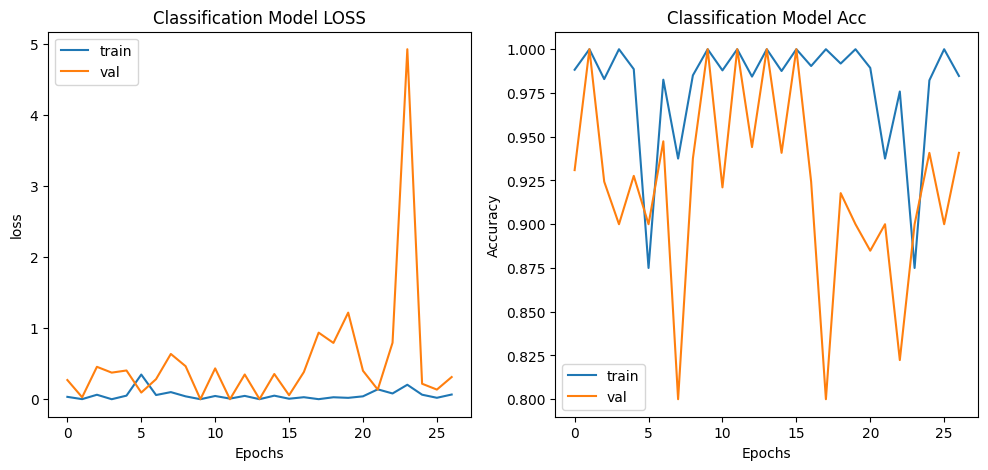

In [84]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [85]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9475 - loss: 0.2187
Test accuracy : 95.54707407951355 %


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
0.955470737913486


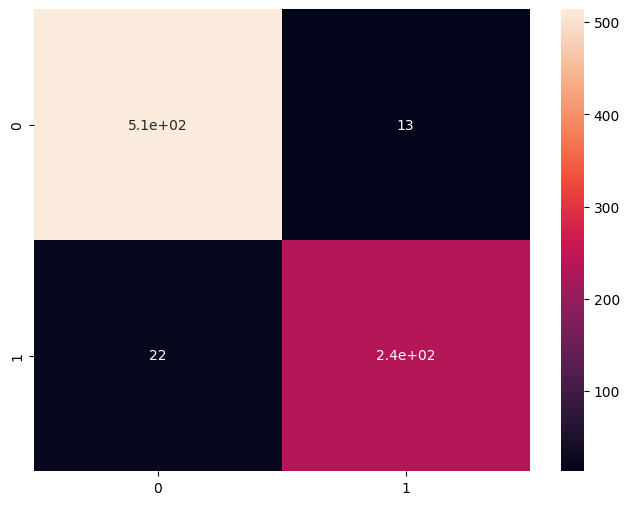

In [86]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
original = np.asarray(test['Tumor']).astype('int')

accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot=True);

In [87]:
report = classification_report(original, pred, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       527
           1       0.95      0.92      0.93       259

    accuracy                           0.96       786
   macro avg       0.95      0.95      0.95       786
weighted avg       0.96      0.96      0.96       786

